# Clasificación de células cervicales en analisis de PAP en 2 clases (Lesión y NoLesión)

## Objetivo

El objetivo del proyecto es clasificar imágenes de células cervicales según si presentan lesiones o no, separando las imágenes en tres conjuntos: entrenamiento (70%), validación (15%) y prueba (15%). Se visualizan imágenes y se preparan para el entrenamiento de un modelo de clasificación binaria.

## 1. Preparación de directorios, carga de datos y visualización de imágenes

In [57]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)

**Preparación de los datos y cargas de imagenes**

In [57]:
# # Directorio de entrada con las imágenes originales
# input_dir = 'crops_90x90'
# # Directorio de salida para las imágenes organizadas
# output_dir = 'crops'

# # Definir carpetas de salida para cada conjunto
# train_dir = os.path.join(output_dir, 'train')
# val_dir = os.path.join(output_dir, 'val')
# test_dir = os.path.join(output_dir, 'test')

# # Crear carpetas principales
# for split_dir in [train_dir, val_dir, test_dir]:
#     os.makedirs(os.path.join(split_dir, '1_lesion'), exist_ok=True)
#     os.makedirs(os.path.join(split_dir, '0_no_lesion', 'Negative'), exist_ok=True)

# # Función para copiar archivos a su destino correspondiente
# def copy_images(images, dest_dir, class_label):
#     lesion_subdir = '1_lesion' if class_label != 'Negative' else '0_no_lesion/Negative'
#     dest_class_dir = os.path.join(dest_dir, lesion_subdir, class_label if class_label != 'Negative' else '')
#     os.makedirs(dest_class_dir, exist_ok=True)
    
#     for img in images:
#         shutil.copy(img, dest_class_dir)

# # Recorrer cada clase en la carpeta de entrada
# for class_name in os.listdir(input_dir):
#     class_path = os.path.join(input_dir, class_name)
    
#     # Asegurarse de que es una carpeta
#     if os.path.isdir(class_path):
#         # Obtener todas las imágenes de esta clase
#         images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

#         # Dividir imágenes en 70% entrenamiento, 15% validación, 15% prueba
#         train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
#         val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

#         # Copiar las imágenes a sus carpetas correspondientes
#         copy_images(train_images, train_dir, class_name)
#         copy_images(val_images, val_dir, class_name)
#         copy_images(test_images, test_dir, class_name)

# print("Imágenes organizadas en carpetas de entrenamiento, validación y prueba dentro de 'crops'.")

**Visualización de Imagenes con y sin Lesiones**

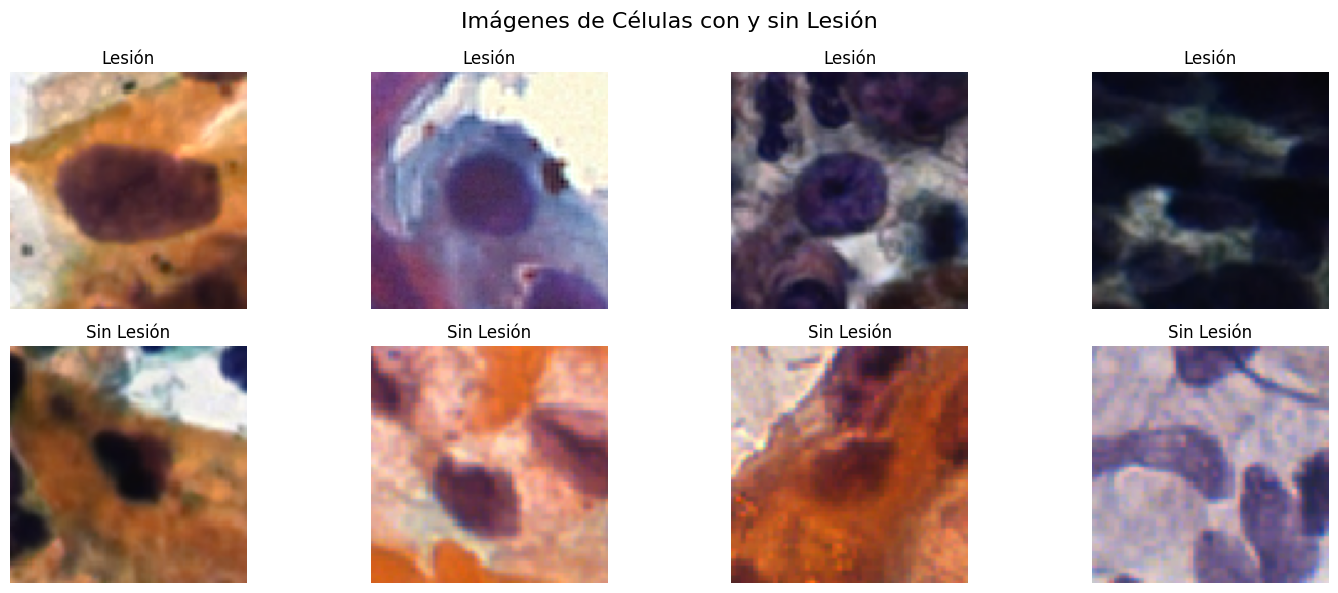

In [137]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Parámetros para la visualización
num_images = 4  # Número de imágenes con y sin lesión que queremos mostrar
image_size = (96, 96)  # Tamaño al que se redimensionarán las imágenes

# Función para visualizar imágenes con y sin lesión
def visualize_images(base_dir, num_images, image_size):
    lesion_folder = os.path.join(base_dir, '1_lesion')
    no_lesion_folder = os.path.join(base_dir, '0_no_lesion', 'Negative')
    
    # Obtener una lista de imágenes con y sin lesión
    lesion_images = []
    for subdir in os.listdir(lesion_folder):
        subdir_path = os.path.join(lesion_folder, subdir)
        if os.path.isdir(subdir_path):
            lesion_images.extend([os.path.join(subdir_path, img) for img in os.listdir(subdir_path)])

    no_lesion_images = [os.path.join(no_lesion_folder, img) for img in os.listdir(no_lesion_folder) if os.path.isfile(os.path.join(no_lesion_folder, img))]

    # Seleccionar aleatoriamente imágenes con y sin lesión
    lesion_images_sample = random.sample(lesion_images, min(num_images, len(lesion_images)))
    no_lesion_images_sample = random.sample(no_lesion_images, min(num_images, len(no_lesion_images)))

    # Visualización
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle('Imágenes de Células con y sin Lesión', fontsize=16)

    # Mostrar imágenes con lesión
    for i, img_path in enumerate(lesion_images_sample):
        img = load_img(img_path, target_size=image_size)
        axes[0, i].imshow(img)
        axes[0, i].set_title("Lesión")
        axes[0, i].axis('off')
    
    # Mostrar imágenes sin lesión
    for i, img_path in enumerate(no_lesion_images_sample):
        img = load_img(img_path, target_size=image_size)
        axes[1, i].imshow(img)
        axes[1, i].set_title("Sin Lesión")
        axes[1, i].axis('off')
    
    # Ajustar el layout
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

# Llamada a la función para visualizar las imágenes
visualize_images('crops/test', num_images, image_size)

**Visualización del Balance de las Clases**

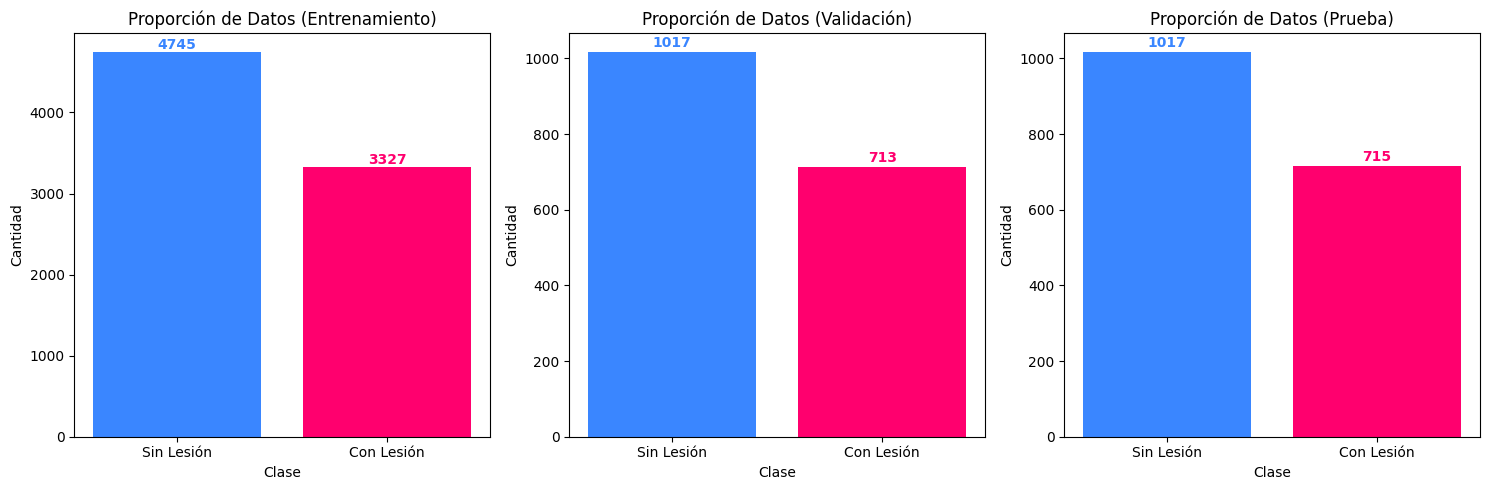

In [138]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes en las carpetas "lesion" y "no lesion" en el nuevo formato
def count_images_in_folders(folder_path):
    lesion_folder = os.path.join(folder_path, '1_lesion')
    no_lesion_folder = os.path.join(folder_path, '0_no_lesion', 'Negative')

    # Contar imágenes en las subcarpetas de "con lesión" y "sin lesión"
    lesion_count = sum(len(files) for _, _, files in os.walk(lesion_folder))
    no_lesion_count = len(os.listdir(no_lesion_folder)) if os.path.exists(no_lesion_folder) else 0

    return lesion_count, no_lesion_count

# Función para crear gráficos de barras para las proporciones
def plot_proportion_subplot(ax, lesion_count, no_lesion_count, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold', color='#3A86FF')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold', color='#FF006E')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops/train'
val_dir = 'crops/val'
test_dir = 'crops/test'

# Contar las imágenes en cada conjunto
train_lesion_count, train_no_lesion_count = count_images_in_folders(train_dir)
val_lesion_count, val_no_lesion_count = count_images_in_folders(val_dir)
test_lesion_count, test_no_lesion_count = count_images_in_folders(test_dir)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_proportion_subplot(axes[0], train_lesion_count, train_no_lesion_count, 'Proporción de Datos (Entrenamiento)')
plot_proportion_subplot(axes[1], val_lesion_count, val_no_lesion_count, 'Proporción de Datos (Validación)')
plot_proportion_subplot(axes[2], test_lesion_count, test_no_lesion_count, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

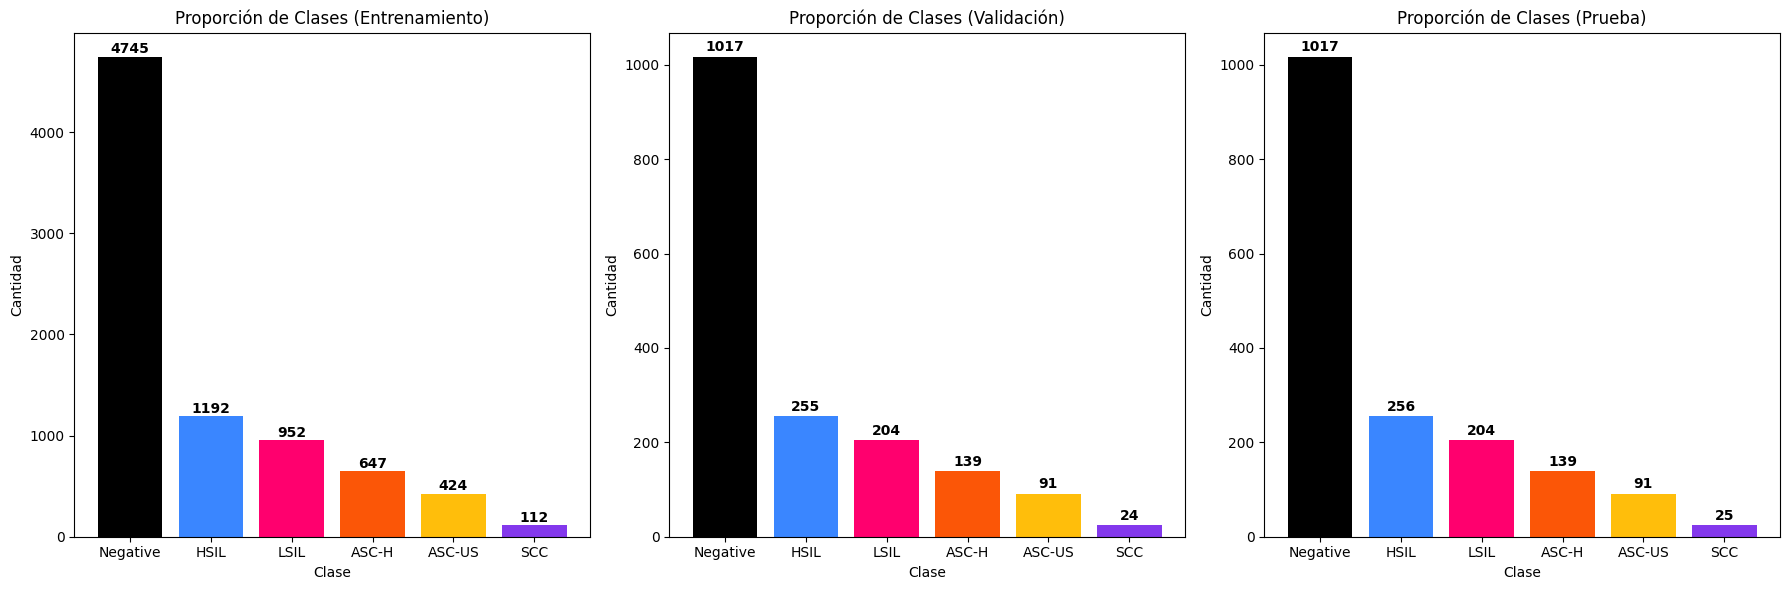

In [139]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes por clase dentro de "lesion" y "no lesion" en el nuevo formato
def count_images_by_class(folder_path):
    # Diccionario para almacenar el conteo de cada clase
    class_counts = {}

    # Contar imágenes en la carpeta "0_no_lesion/Negative"
    no_lesion_folder = os.path.join(folder_path, '0_no_lesion', 'Negative')
    class_counts['Negative'] = len(os.listdir(no_lesion_folder)) if os.path.exists(no_lesion_folder) else 0

    # Contar imágenes en cada subcarpeta de "1_lesion"
    lesion_folder = os.path.join(folder_path, '1_lesion')
    for lesion_class in os.listdir(lesion_folder):
        lesion_class_path = os.path.join(lesion_folder, lesion_class)
        if os.path.isdir(lesion_class_path):
            class_counts[lesion_class] = len(os.listdir(lesion_class_path))

    return class_counts

# Función para crear gráficos de barras para las proporciones de cada clase
def plot_class_proportion(ax, class_counts, title, colors):
    # Crear el gráfico de barras en el subplot
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    ax.bar(classes, counts, color=colors[:len(classes)])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    for i, count in enumerate(counts):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops/train'
val_dir = 'crops/val'
test_dir = 'crops/test'

# Contar las imágenes en cada conjunto por clase
train_class_counts = count_images_by_class(train_dir)
val_class_counts = count_images_by_class(val_dir)
test_class_counts = count_images_by_class(test_dir)

# Colores para cada clase
colors = ['#000000', '#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC']  # Negro para 'Negative' y colores para las clases con lesión

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_class_proportion(axes[0], train_class_counts, 'Proporción de Clases (Entrenamiento)', colors)
plot_class_proportion(axes[1], val_class_counts, 'Proporción de Clases (Validación)', colors)
plot_class_proportion(axes[2], test_class_counts, 'Proporción de Clases (Prueba)', colors)

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

## 2. Aumentación de Datos para la Clase Minoritaria

El objetivo de este proceso es generar imágenes augmentadas para las clases minoritarias SCC, ASC-US, y ASC-H en el conjunto de entrenamiento, utilizando técnicas de aumentación de datos como rotación, volteo horizontal y vertical, y ajustes de brillo. Estas transformaciones ayudan a aumentar la variabilidad de las imágenes de la clase con lesión, reduciendo el desequilibrio de clases y mejorando la capacidad del modelo para generalizar. 
Este proceso generará aproximadamente 1.5 veces la cantidad actual de cada clase minoritaria, de modo que se acerquen a la proporción de las clases mayoritarias (LSIL y HSIL) sin sobrecargar el modelo con demasiados datos.

In [144]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

# Directorio de entrenamiento
train_dir = 'crops_aug/train/1_lesion'

# Clases minoritarias para las que realizaremos aumentación
minority_classes = {
    'SCC': 112,
    'ASC-US': 424,
    'ASC-H': 647
}

# Objetivo de aumentación
augmentation_targets = {
    'SCC': 168,
    'ASC-US': 636,
    'ASC-H': 970
}

# Configuración de aumentación
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Función para generar imágenes aumentadas
def augment_class_images(class_name, current_count, target_count):
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)

    # Generar imágenes hasta alcanzar el target_count
    while current_count < target_count:
        img_path = os.path.join(class_dir, np.random.choice(image_files))
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Generar una imagen aumentada
        aug_iter = datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)

        # Guardar la imagen aumentada
        new_img_name = f"{class_name}_aug_{current_count}.png"
        save_img(os.path.join(class_dir, new_img_name), aug_img)
        
        current_count += 1

# Aplicar aumentación a cada clase minoritaria
for class_name, current_count in minority_classes.items():
    target_count = augmentation_targets[class_name]
    print(f"Generando aumentación para la clase {class_name}: de {current_count} a {target_count} imágenes.")
    augment_class_images(class_name, current_count, target_count)

print("Aumentación de datos completada para las clases minoritarias.")

Generando aumentación para la clase SCC: de 112 a 168 imágenes.
Generando aumentación para la clase ASC-US: de 424 a 636 imágenes.
Generando aumentación para la clase ASC-H: de 647 a 970 imágenes.
Aumentación de datos completada para las clases minoritarias.


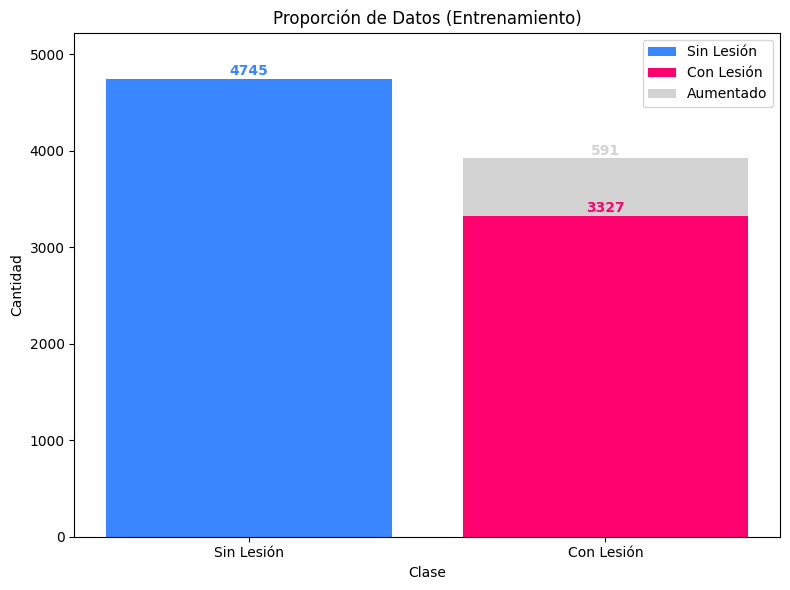

In [145]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes en las carpetas, incluyendo las aumentadas basadas en el prefijo del nombre
def count_images_in_folders(folder_path):
    lesion_count = 0
    no_lesion_count = 0
    augmented_count = 0

    lesion_folder_path = os.path.join(folder_path, '1_lesion')
    no_lesion_folder_path = os.path.join(folder_path, '0_no_lesion', 'Negative')
    
    # Contar imágenes originales y aumentadas en "con lesión"
    if os.path.exists(lesion_folder_path):
        for class_folder in os.listdir(lesion_folder_path):
            class_folder_path = os.path.join(lesion_folder_path, class_folder)
            if os.path.isdir(class_folder_path):
                for img_file in os.listdir(class_folder_path):
                    # Verificar si el nombre del archivo coincide con el patrón de aumento
                    if "_aug_" in img_file:
                        augmented_count += 1
                    else:
                        lesion_count += 1

    # Contar imágenes en "sin lesión" (clase Negative)
    if os.path.exists(no_lesion_folder_path):
        no_lesion_count = len(os.listdir(no_lesion_folder_path))

    return lesion_count, no_lesion_count, augmented_count

# Función para crear el gráfico de barras, incluyendo augmentación
def plot_proportion_train(lesion_count, no_lesion_count, augmented_count):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Graficar datos originales y augmentados
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'], label=['Sin Lesión', 'Con Lesión'])
    ax.bar(['Sin Lesión', 'Con Lesión'], [0, augmented_count], bottom=[no_lesion_count, lesion_count], 
           color='#D3D3D3', label='Aumentado')  # Color distinto para los aumentados
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title('Proporción de Datos (Entrenamiento)')
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold', color='#3A86FF')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold', color='#FF006E')
    ax.text(1, lesion_count + augmented_count + 5, f"{augmented_count}", ha='center', va='bottom', fontweight='bold', color='#D3D3D3')
    
    # Ajustar el límite del eje y
    ax.set_ylim(0, max(no_lesion_count, lesion_count + augmented_count) * 1.1)

    # Añadir leyenda
    ax.legend()
    plt.tight_layout()
    plt.show()

# Directorio de entrenamiento
train_dir = 'crops_aug/train'

# Contar las imágenes en el conjunto de entrenamiento
train_lesion_count, train_no_lesion_count, train_augmented_count = count_images_in_folders(train_dir)

# Crear gráfico de entrenamiento con datos augmentados
plot_proportion_train(train_lesion_count, train_no_lesion_count, train_augmented_count)

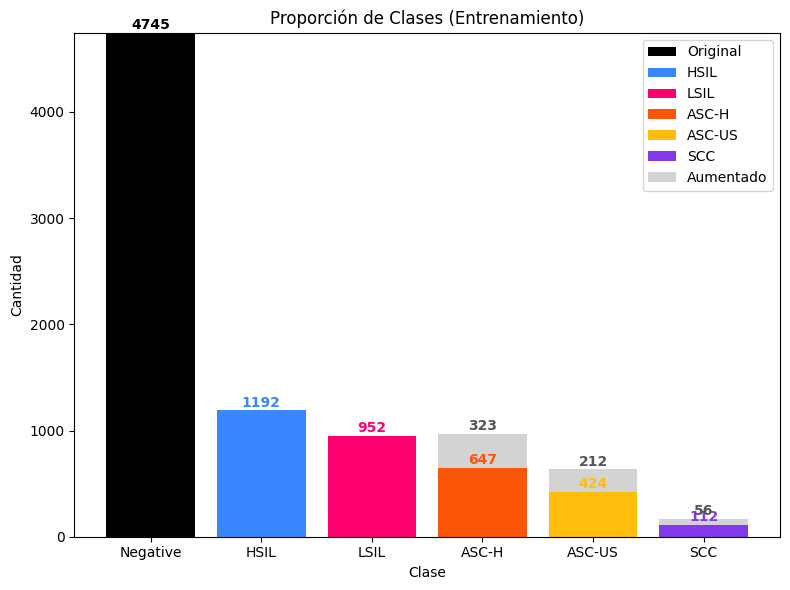

In [146]:
import os
import matplotlib.pyplot as plt

# Función para contar imágenes originales y aumentadas por clase en el conjunto de entrenamiento
def count_images_by_class_with_augmentation(folder_path):
    class_counts = {}
    augmented_counts = {}

    # Contar imágenes en la carpeta "0_no_lesion/Negative"
    no_lesion_folder = os.path.join(folder_path, '0_no_lesion', 'Negative')
    class_counts['Negative'] = len([img for img in os.listdir(no_lesion_folder) if "_aug_" not in img]) if os.path.exists(no_lesion_folder) else 0
    augmented_counts['Negative'] = len([img for img in os.listdir(no_lesion_folder) if "_aug_" in img]) if os.path.exists(no_lesion_folder) else 0

    # Contar imágenes en cada subcarpeta de "1_lesion"
    lesion_folder = os.path.join(folder_path, '1_lesion')
    for lesion_class in os.listdir(lesion_folder):
        lesion_class_path = os.path.join(lesion_folder, lesion_class)
        if os.path.isdir(lesion_class_path):
            class_counts[lesion_class] = len([img for img in os.listdir(lesion_class_path) if "_aug_" not in img])
            augmented_counts[lesion_class] = len([img for img in os.listdir(lesion_class_path) if "_aug_" in img])

    return class_counts, augmented_counts

# Función para crear el gráfico de barras del conjunto de entrenamiento, incluyendo aumentación
def plot_class_proportion_with_augmentation(class_counts, augmented_counts, title, colors):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    augmented = [augmented_counts[cls] for cls in classes]

    # Graficar datos originales y augmentados
    bars_original = ax.bar(classes, counts, color=colors[:len(classes)], label=['Original', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC'])
    bars_augmented = ax.bar(classes, augmented, bottom=counts, color='#D3D3D3', label='Aumentado')  # Color gris claro para aumentados

    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)

    # Agregar etiquetas de cantidad en las barras, con el color de cada barra
    for bar, count, color in zip(bars_original, counts, colors):
        ax.text(bar.get_x() + bar.get_width() / 2, count + 5, str(count), ha='center', va='bottom', fontweight='bold', color=color)
    
    for bar, count, aug in zip(bars_augmented, counts, augmented):
        if aug > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, count + aug + 5, str(aug), ha='center', va='bottom', fontweight='bold', color='#555555')

    # Añadir leyenda y mostrar gráfico
    ax.legend()
    plt.tight_layout()
    plt.show()

# Directorio de entrenamiento
train_dir = 'crops_aug/train'

# Contar las imágenes en el conjunto de entrenamiento
train_class_counts, train_augmented_counts = count_images_by_class_with_augmentation(train_dir)

# Colores para cada clase
colors = ['#000000', '#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC']

# Crear gráfico solo del conjunto de entrenamiento con datos aumentados
plot_class_proportion_with_augmentation(train_class_counts, train_augmented_counts, 'Proporción de Clases (Entrenamiento)', colors)

## 3. Generación de imagenes

In [147]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios de entrenamiento, validación y prueba en la nueva estructura de carpetas
train_dir = 'crops_aug/train'
val_dir = 'crops_aug/val'
test_dir = 'crops_aug/test'

# Configuración del generador de imágenes con reescalado
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de imágenes para el entrenamiento binario completo (con y sin lesión)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    classes=['0_no_lesion', '1_lesion']  # Asegurarse de que solo se usen las clases correctas
)

# Generadores para validación y prueba (binarios)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['0_no_lesion', '1_lesion']
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['0_no_lesion', '1_lesion']
)

Found 8663 images belonging to 2 classes.
Found 1730 images belonging to 2 classes.
Found 1732 images belonging to 2 classes.


## 4. Entrenamiento y Evaluación de modelos de clasificación binaria

### MovileNetV2

In [ ]:
# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), f1_score])  #tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
284/284 [==============================] - 20s 64ms/step - loss: 0.4499 - accuracy: 0.7889 - precision: 0.7696 - recall: 0.7957 - auc: 0.8741 - f1_score: 0.6459 - val_loss: 0.7335 - val_accuracy: 0.7474 - val_precision: 0.9286 - val_recall: 0.4194 - val_auc: 0.8941 - val_f1_score: 0.5837
Epoch 2/30
284/284 [==============================] - 17s 60ms/step - loss: 0.2712 - accuracy: 0.8861 - precision: 0.8750 - recall: 0.8882 - auc: 0.9550 - f1_score: 0.6459 - val_loss: 0.4871 - val_accuracy: 0.8087 - val_precision: 0.9099 - val_recall: 0.5947 - val_auc: 0.9204 - val_f1_score: 0.5837
Epoch 3/30
284/284 [==============================] - 17s 61ms/step - loss: 0.1807 - accuracy: 0.9268 - precision: 0.9204 - recall: 0.9268 - auc: 0.9805 - f1_score: 0.6460 - val_loss: 0.7045 - val_accuracy: 0.7763 - val_precision: 0.9503 - val_recall: 0.4825 - val_auc: 0.9234 - val_f1_score: 0.5842
Epoch 4/30
284/284 [==============================] - 18s 64ms/step - loss: 0.1320 - accuracy: 0.946

InvalidArgumentError: Graph execution error:

'dim' must be a tensor with a single value
	 [[{{node ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_bool_ExpandDims}}]] [Op:__inference_test_function_300881]

#### Evaluación

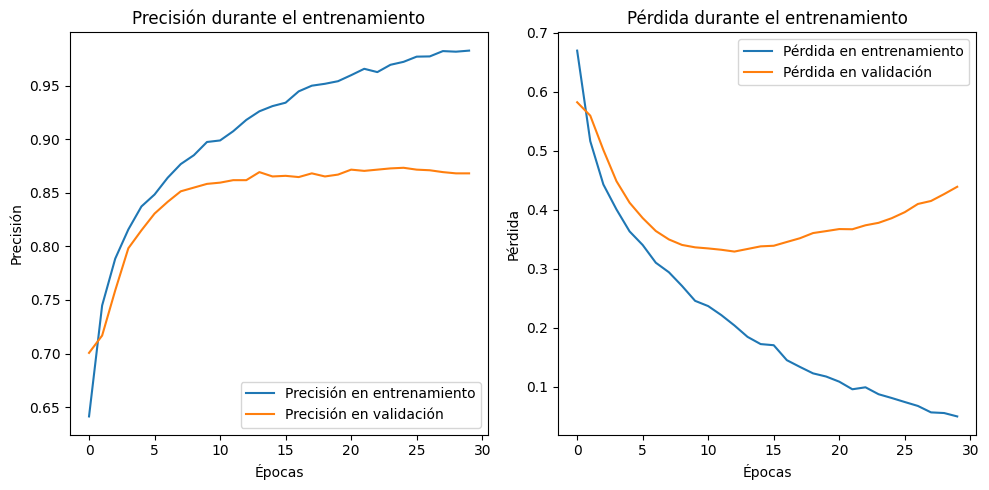

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

# 55/55 [==============================] - 2s 29ms/step - loss: 0.3659 - accuracy: 0.8758 - precision: 0.8675 - recall: 0.8249 - auc: 0.9414 - f1_score: 0.5840
# Pérdida en el conjunto de prueba: 0.36590656638145447
# accuracy en el conjunto de prueba: 0.8757943511009216
# Precision en el conjunto de prueba: 0.8674521446228027
# Recall en el conjunto de prueba: 0.82492995262146
# AUC en el conjunto de prueba: 0.9414162039756775
# F1-Score en el conjunto de prueba: [0.58404905]

55/55 [==============================] - 2s 36ms/step - loss: 0.4060 - accuracy: 0.8798 - precision: 0.8929 - recall: 0.8053 - auc: 0.9379 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.40602320432662964
accuracy en el conjunto de prueba: 0.879838228225708
Precision en el conjunto de prueba: 0.8928571343421936
Recall en el conjunto de prueba: 0.8053221106529236
AUC en el conjunto de prueba: 0.9378726482391357
F1-Score en el conjunto de prueba: [0.58404905]


**Matriz de confusión**

55/55 [==============================] - 2s 34ms/step


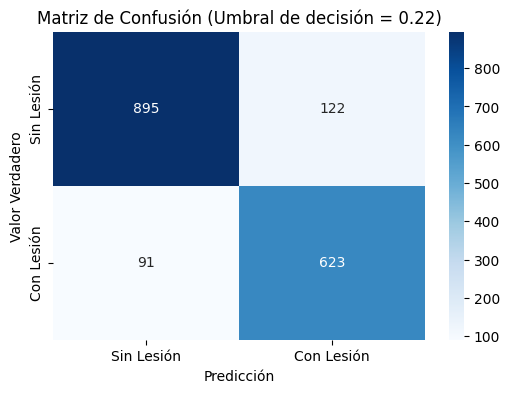

Recall (con umbral = 0.22): 0.8725490196078431
Precisión (con umbral = 0.22): 0.836241610738255


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.22  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 2s 35ms/step


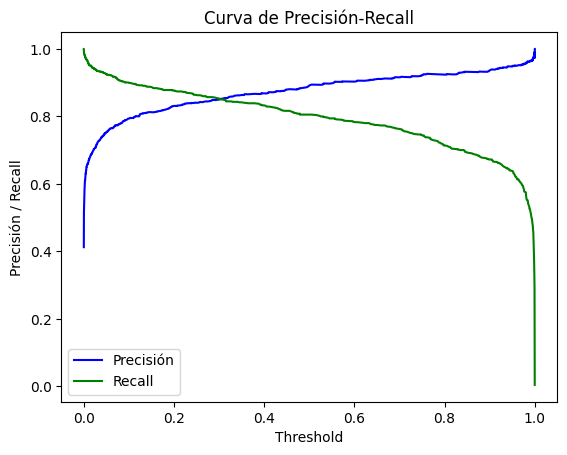

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

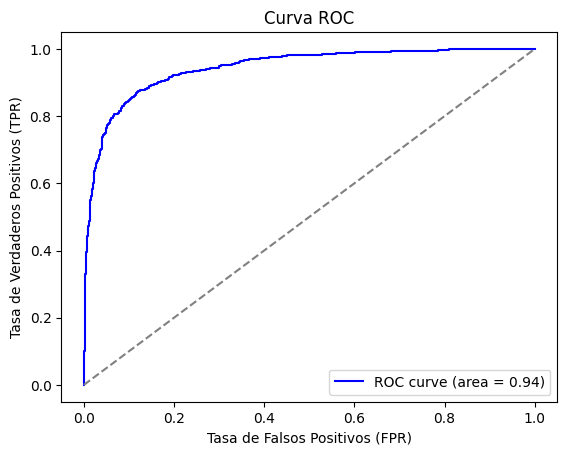

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.22
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.7435897435897436
Recall: 0.9341736694677871
F1-Score: 0.8280571073867162
AUC: 0.945376774111808


In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 2s 36ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.22
Mejor F1-score: 0.8540095956134339


### MobileNetV3

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-4),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
284/284 [==============================] - 13s 28ms/step - loss: 0.6223 - accuracy: 0.6533 - precision: 0.6389 - recall: 0.6282 - auc: 0.7132 - f1_score: 0.6459 - val_loss: 0.6905 - val_accuracy: 0.5861 - val_precision: 0.4800 - val_recall: 0.0505 - val_auc: 0.5598 - val_f1_score: 0.5837
Epoch 2/30
284/284 [==============================] - 7s 23ms/step - loss: 0.5517 - accuracy: 0.7225 - precision: 0.7021 - recall: 0.7264 - auc: 0.7941 - f1_score: 0.6459 - val_loss: 0.6916 - val_accuracy: 0.5821 - val_precision: 0.3810 - val_recall: 0.0224 - val_auc: 0.4239 - val_f1_score: 0.5837
Epoch 3/30
284/284 [==============================] - 7s 24ms/step - loss: 0.5163 - accuracy: 0.7542 - precision: 0.7327 - recall: 0.7632 - auc: 0.8245 - f1_score: 0.6459 - val_loss: 0.6931 - val_accuracy: 0.5289 - val_precision: 0.3658 - val_recall: 0.1950 - val_auc: 0.4448 - val_f1_score: 0.5837
Epoch 4/30
284/284 [==============================] - 7s 23ms/step - loss: 0.5022 - accuracy: 0.7614 -

#### Evaluación

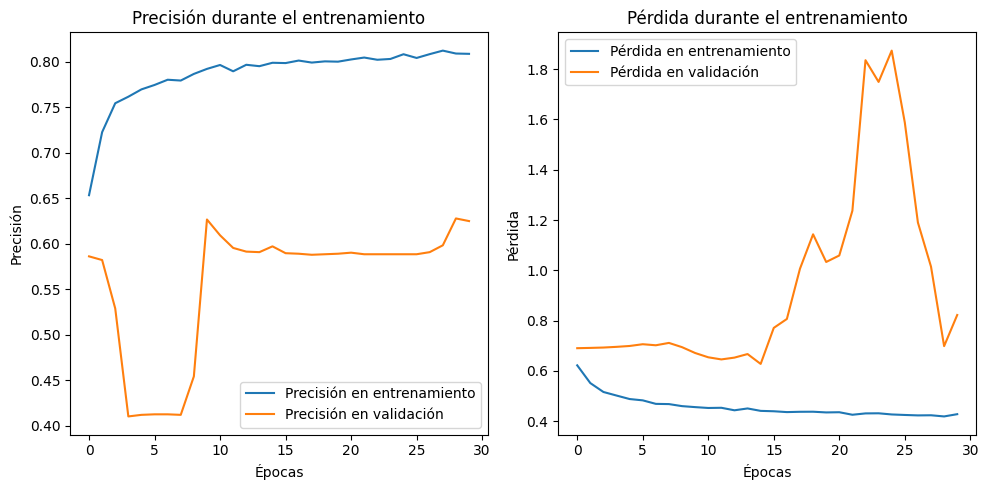

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 1s 23ms/step - loss: 0.8213 - accuracy: 0.6320 - precision: 0.9326 - recall: 0.1162 - auc: 0.8956 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.821283221244812
accuracy en el conjunto de prueba: 0.6320046186447144
Precision en el conjunto de prueba: 0.932584285736084
Recall en el conjunto de prueba: 0.11624649912118912
AUC en el conjunto de prueba: 0.8955858945846558
F1-Score en el conjunto de prueba: [0.58404905]


**Matriz de confusión**

55/55 [==============================] - 1s 23ms/step


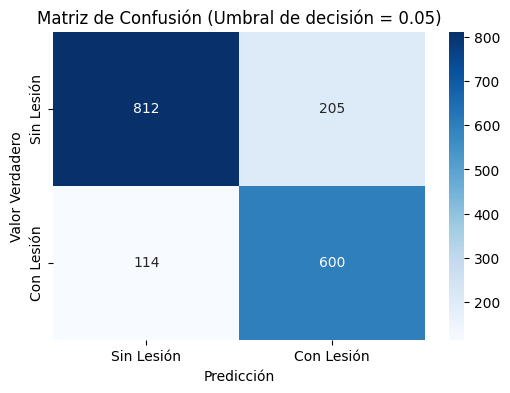

Recall (con umbral = 0.05): 0.8403361344537815
Precisión (con umbral = 0.05): 0.7453416149068323


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.05  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 1s 19ms/step


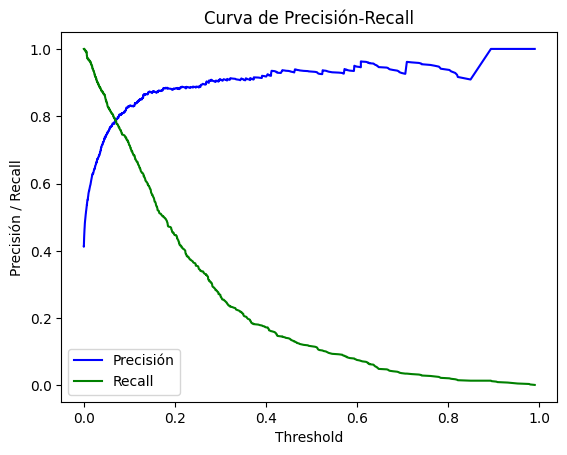

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

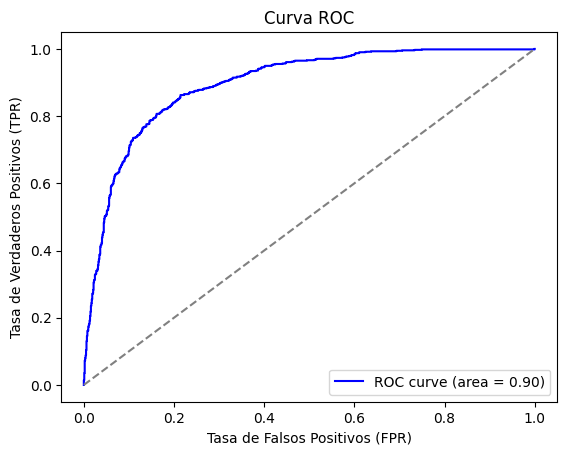

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.5696619950535862
Recall: 0.9677871148459384
F1-Score: 0.7171769590036325
AUC: 0.8900883854033256


In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 1s 20ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.05
Mejor F1-score: 0.7899934167215273


### EfficientNetB0

In [ ]:
# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Cambiar para descongelar solo las últimas 10 capas
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
    class_weight={0: 1., 1: 3.0}  # Ajustar class_weight para clases desbalanceadas
)

Epoch 1/30
253/253 [==============================] - 22s 77ms/step - loss: 1.3357 - accuracy: 0.4252 - precision: 0.4123 - recall: 0.9261 - auc: 0.5103 - f1_score: 0.5103 - val_loss: 0.8476 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.4950 - val_f1_score: 0.4950 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 18s 71ms/step - loss: 1.2852 - accuracy: 0.4146 - precision: 0.4109 - recall: 0.9684 - auc: 0.5287 - f1_score: 0.5287 - val_loss: 0.8796 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7397 - val_f1_score: 0.7397 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 18s 72ms/step - loss: 1.2630 - accuracy: 0.4219 - precision: 0.4147 - recall: 0.9775 - auc: 0.5591 - f1_score: 0.5591 - val_loss: 0.8501 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7839 - val_f1_score: 0.7839 - lr: 1.0000e-04
Epoch 4/30
253/253 [=============================

#### Evaluación

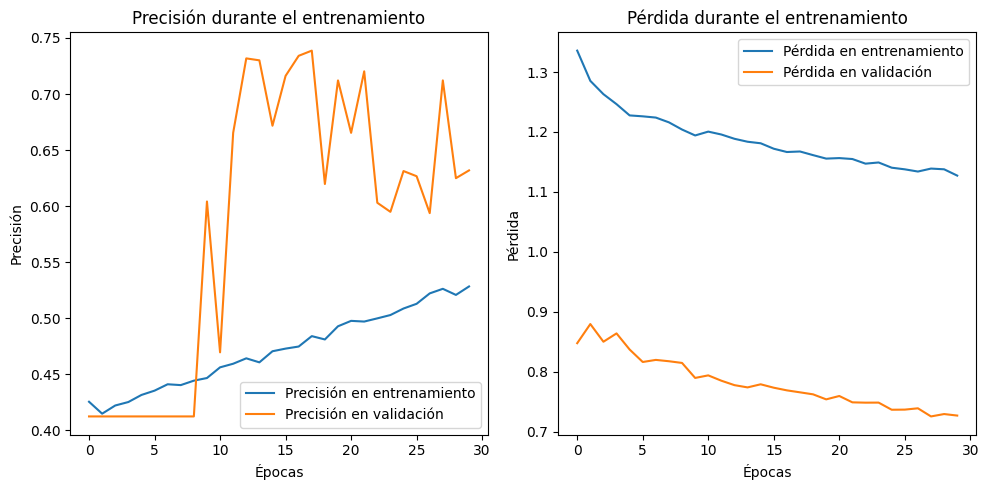

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 3s 58ms/step - loss: 0.7291 - accuracy: 0.6424 - precision: 0.8369 - recall: 0.1653 - auc: 0.7936 - f1_score: 0.7936
Pérdida en el conjunto de prueba: 0.7291462421417236
accuracy en el conjunto de prueba: 0.642403244972229
Precision en el conjunto de prueba: 0.8368794322013855
Recall en el conjunto de prueba: 0.16526611149311066
AUC en el conjunto de prueba: 0.7935826182365417
F1-Score en el conjunto de prueba: 0.7935826182365417


**Matriz de confusión**

55/55 [==============================] - 3s 57ms/step


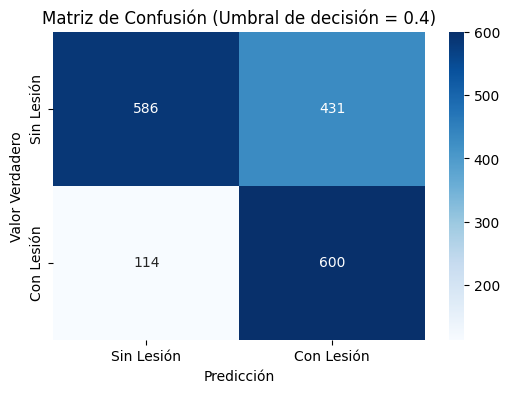

Recall (con umbral = 0.4): 0.8403361344537815
Precisión (con umbral = 0.4): 0.5819592628516004


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.4  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 3s 57ms/step


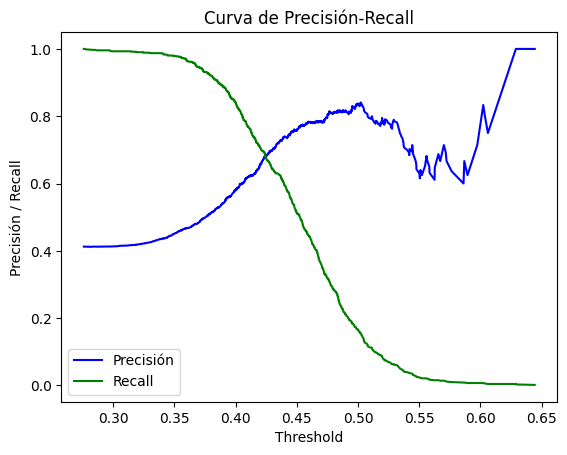

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

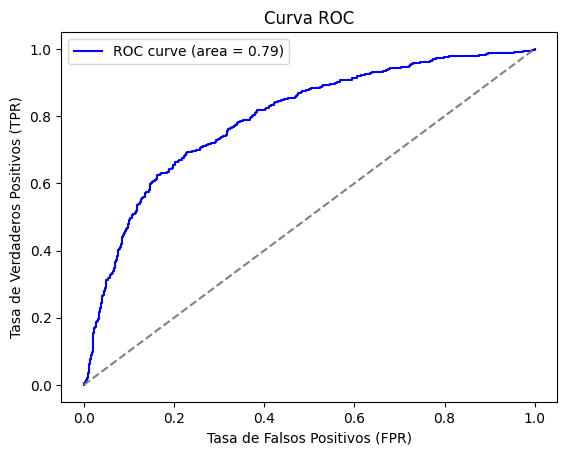

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 3s 60ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.4
Mejor F1-score: 0.6876790830945558


### ResNet

In [ ]:
# Cargar ResNet50 preentrenado en ImageNet, sin la capa superior
base_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Incrementar el dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar algunas capas del modelo base para ajustar los pesos
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Ajusta el número de capas descongeladas si es necesario
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Aplicar class_weight para manejar el desbalanceo de clases
class_weight = {0: 1., 1: 3.5}  # Dar más peso a la clase con "lesión"

history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30
253/253 [==============================] - 84s 325ms/step - loss: 0.4925 - accuracy: 0.7551 - precision: 0.7075 - recall: 0.6920 - auc: 0.8330 - f1_score: 0.5838 - val_loss: 0.6210 - val_accuracy: 0.6387 - val_precision: 0.5357 - val_recall: 0.9257 - val_auc: 0.8280 - val_f1_score: 0.5837
Epoch 2/30
253/253 [==============================] - 81s 321ms/step - loss: 0.4327 - accuracy: 0.7983 - precision: 0.7549 - recall: 0.7563 - auc: 0.8765 - f1_score: 0.5838 - val_loss: 0.4052 - val_accuracy: 0.8197 - val_precision: 0.8463 - val_recall: 0.6872 - val_auc: 0.9006 - val_f1_score: 0.5837
Epoch 3/30
253/253 [==============================] - 88s 349ms/step - loss: 0.4170 - accuracy: 0.8117 - precision: 0.7739 - recall: 0.7674 - auc: 0.8859 - f1_score: 0.5838 - val_loss: 0.4363 - val_accuracy: 0.7931 - val_precision: 0.8884 - val_recall: 0.5694 - val_auc: 0.9034 - val_f1_score: 0.5837
Epoch 4/30
253/253 [==============================] - 83s 330ms/step - loss: 0.4051 - accuracy: 0

#### Evaluación

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 8s 150ms/step - loss: 0.5589 - accuracy: 0.7880 - precision: 0.8505 - recall: 0.5896 - auc: 0.8801 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.5589182376861572
accuracy en el conjunto de prueba: 0.7879838347434998
Precision en el conjunto de prueba: 0.8505050539970398
Recall en el conjunto de prueba: 0.5896358489990234
AUC en el conjunto de prueba: 0.8801308870315552
F1-Score en el conjunto de prueba: [0.58404905]


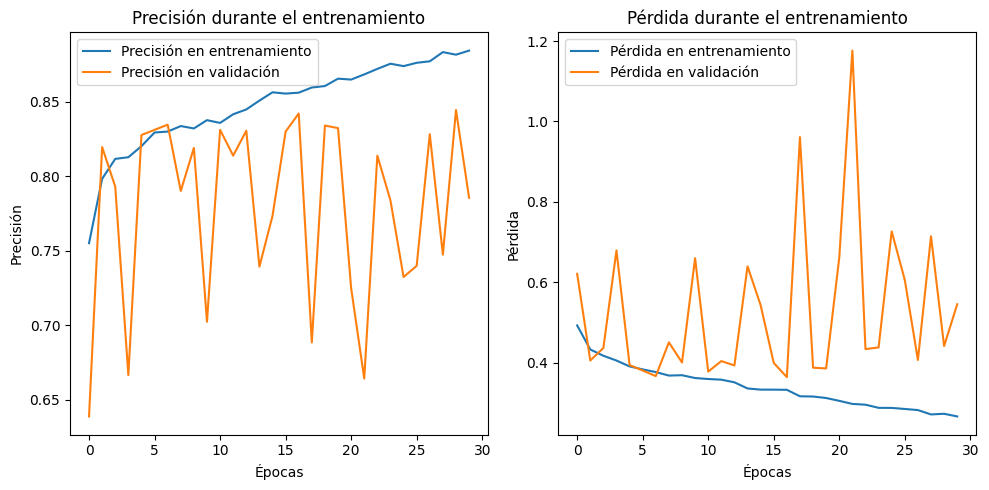

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Matriz de confusión**

55/55 [==============================] - 9s 160ms/step


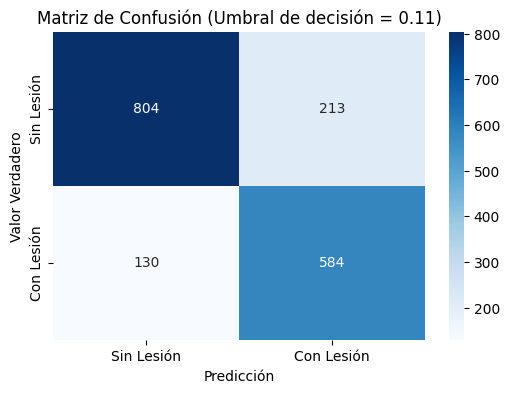

Recall (con umbral = 0.11): 0.8179271708683473
Precisión (con umbral = 0.11): 0.7327478042659975


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.11  # Ajusta este valor (ej. 0.3) para mejorar el recall

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegurar que y_true tenga el mismo tamaño que y_pred

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 8s 152ms/step


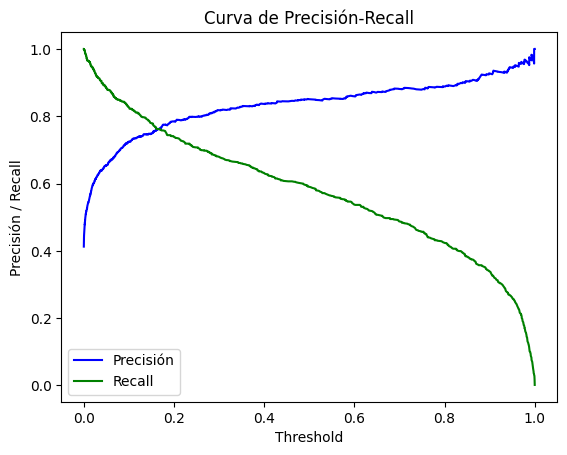

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

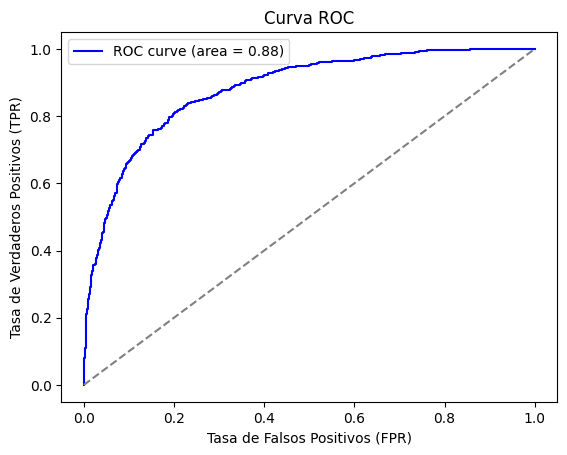

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

55/55 [==============================] - 9s 170ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.11
Mejor F1-score: 0.7729980145598941


### EfficientNetB0

In [ ]:
# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Cambiar para descongelar solo las últimas 10 capas
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
    class_weight={0: 1., 1: 3.0}  # Ajustar class_weight para clases desbalanceadas
)

Epoch 1/30
253/253 [==============================] - 22s 77ms/step - loss: 1.3357 - accuracy: 0.4252 - precision: 0.4123 - recall: 0.9261 - auc: 0.5103 - f1_score: 0.5103 - val_loss: 0.8476 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.4950 - val_f1_score: 0.4950 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 18s 71ms/step - loss: 1.2852 - accuracy: 0.4146 - precision: 0.4109 - recall: 0.9684 - auc: 0.5287 - f1_score: 0.5287 - val_loss: 0.8796 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7397 - val_f1_score: 0.7397 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 18s 72ms/step - loss: 1.2630 - accuracy: 0.4219 - precision: 0.4147 - recall: 0.9775 - auc: 0.5591 - f1_score: 0.5591 - val_loss: 0.8501 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7839 - val_f1_score: 0.7839 - lr: 1.0000e-04
Epoch 4/30
253/253 [=============================

#### Evaluación

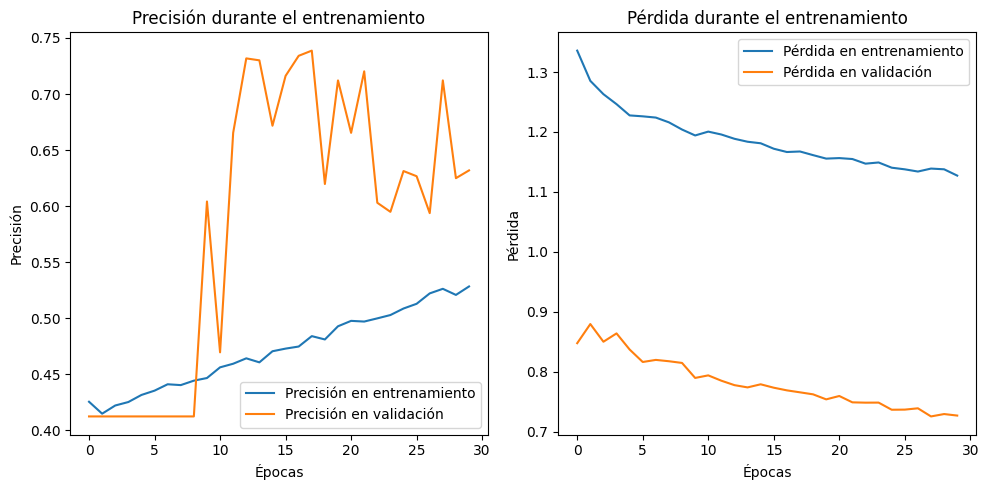

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 3s 58ms/step - loss: 0.7291 - accuracy: 0.6424 - precision: 0.8369 - recall: 0.1653 - auc: 0.7936 - f1_score: 0.7936
Pérdida en el conjunto de prueba: 0.7291462421417236
accuracy en el conjunto de prueba: 0.642403244972229
Precision en el conjunto de prueba: 0.8368794322013855
Recall en el conjunto de prueba: 0.16526611149311066
AUC en el conjunto de prueba: 0.7935826182365417
F1-Score en el conjunto de prueba: 0.7935826182365417


**Matriz de confusión**

55/55 [==============================] - 3s 57ms/step


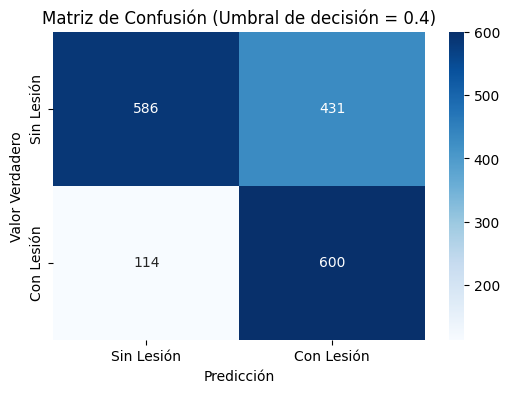

Recall (con umbral = 0.4): 0.8403361344537815
Precisión (con umbral = 0.4): 0.5819592628516004


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.4  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 3s 57ms/step


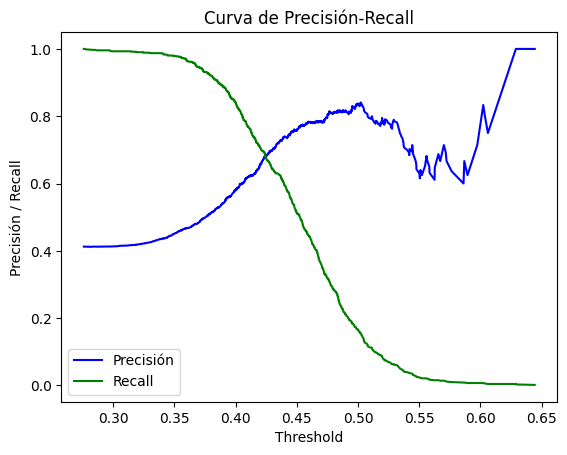

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

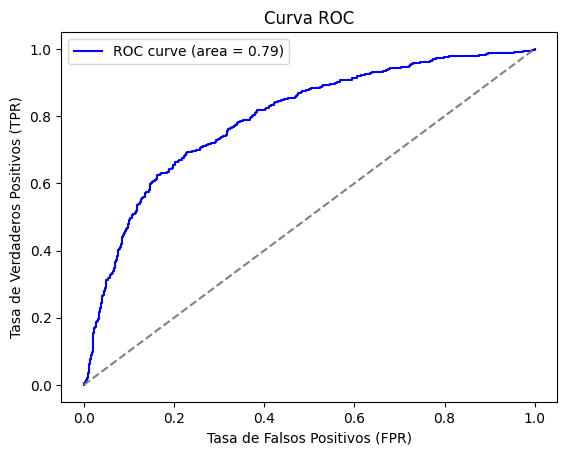

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 3s 60ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.4
Mejor F1-score: 0.6876790830945558


### EfficientNetB6

In [ ]:
# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB6(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Cambiar para descongelar solo las últimas 10 capas
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau 
)

165234480/165234480 [==============================] - 12s 0us/step
Epoch 1/30
284/284 [==============================] - 99s 315ms/step - loss: 0.8230 - accuracy: 0.5123 - precision: 0.4868 - recall: 0.4147 - auc: 0.5146 - f1_score: 0.5146 - val_loss: 0.8199 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.5717 - val_f1_score: 0.5717 - lr: 1.0000e-04
Epoch 2/30
284/284 [==============================] - 83s 293ms/step - loss: 0.7980 - accuracy: 0.5240 - precision: 0.5015 - recall: 0.3533 - auc: 0.5267 - f1_score: 0.5267 - val_loss: 0.7774 - val_accuracy: 0.6133 - val_precision: 0.5733 - val_recall: 0.2412 - val_auc: 0.6080 - val_f1_score: 0.6080 - lr: 1.0000e-04
Epoch 3/30
284/284 [==============================] - 84s 297ms/step - loss: 0.7825 - accuracy: 0.5423 - precision: 0.5301 - recall: 0.3563 - auc: 0.5473 - f1_score: 0.5473 - val_loss: 0.7669 - val_accuracy: 0.6075 - val_precision: 0.6062 - val_recall: 0.1360 - val_auc: 0.6172 - val_f1_score: 0.

#### Evaluación

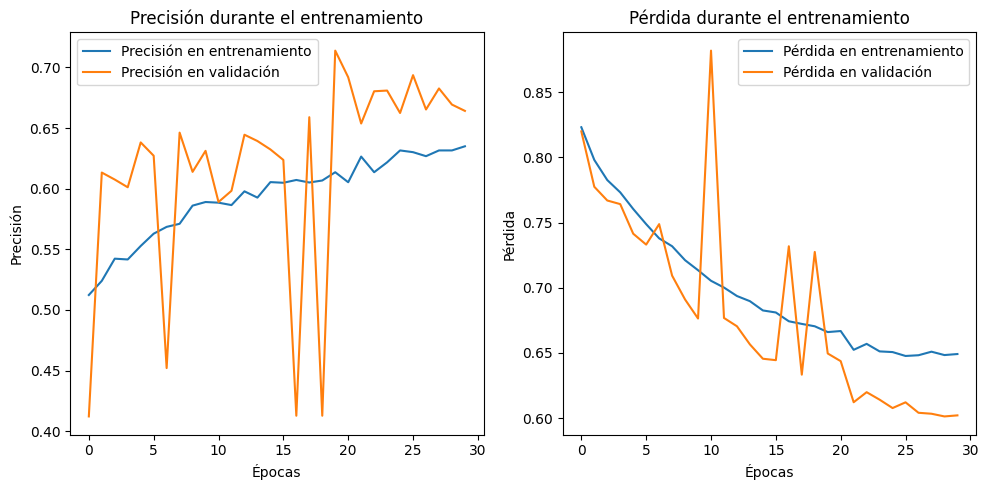

In [ ]:
# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 14s 260ms/step - loss: 0.5962 - accuracy: 0.6742 - precision: 0.7206 - recall: 0.3431 - auc: 0.7889 - f1_score: 0.7889
Pérdida en el conjunto de prueba: 0.5962381362915039
accuracy en el conjunto de prueba: 0.6741767525672913
Precision en el conjunto de prueba: 0.720588207244873
Recall en el conjunto de prueba: 0.343137264251709
AUC en el conjunto de prueba: 0.7889147996902466
F1-Score en el conjunto de prueba: 0.7889147996902466


**Matriz de confusión**

55/55 [==============================] - 13s 227ms/step


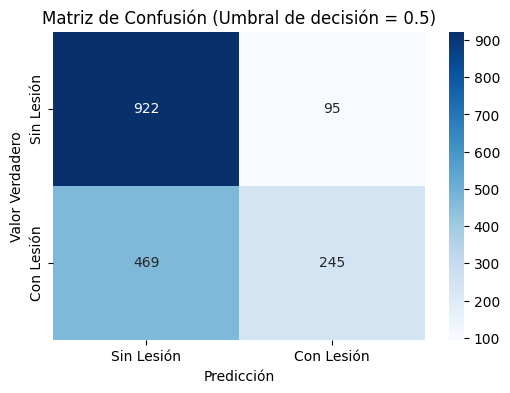

Recall (con umbral = 0.5): 0.3431372549019608
Precisión (con umbral = 0.5): 0.7205882352941176


In [ ]:
# Definir el nuevo umbral de decisión
threshold = 0.5  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 13s 238ms/step


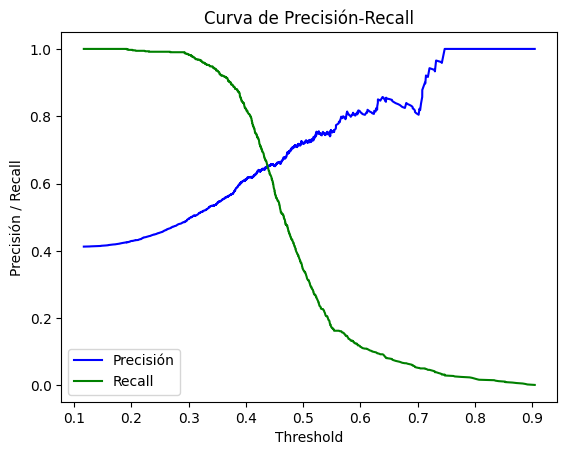

In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

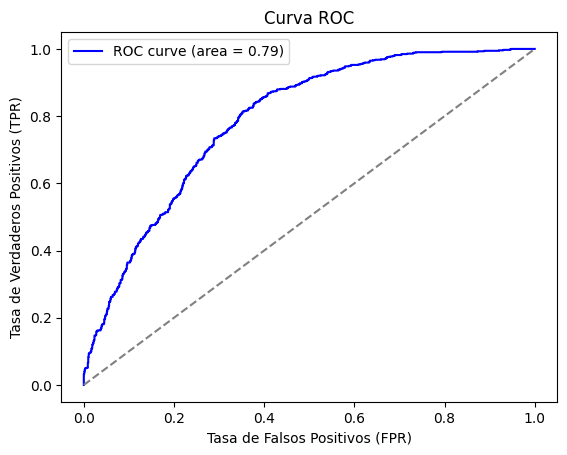

In [ ]:
# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [ ]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 13s 239ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.39
Mejor F1-score: 0.7050691244239632


### XceptionNet

In [81]:
from tensorflow.keras.applications import Xception

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = Xception(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 50% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc')])  #tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
253/253 [==============================] - 103s 399ms/step - loss: 0.6159 - accuracy: 0.6246 - precision: 0.6187 - recall: 0.2326 - auc: 0.7050 - val_loss: 0.5412 - val_accuracy: 0.6613 - val_precision: 0.8396 - val_recall: 0.2202 - val_auc: 0.8431
Epoch 2/30
253/253 [==============================] - 96s 380ms/step - loss: 0.5284 - accuracy: 0.6982 - precision: 0.7663 - recall: 0.3853 - auc: 0.8371 - val_loss: 0.5123 - val_accuracy: 0.7347 - val_precision: 0.8009 - val_recall: 0.4741 - val_auc: 0.8594
Epoch 3/30
253/253 [==============================] - 95s 377ms/step - loss: 0.4848 - accuracy: 0.7604 - precision: 0.7998 - recall: 0.5585 - auc: 0.8728 - val_loss: 0.4868 - val_accuracy: 0.7988 - val_precision: 0.8088 - val_recall: 0.6704 - val_auc: 0.8768
Epoch 4/30
253/253 [==============================] - 95s 374ms/step - loss: 0.4333 - accuracy: 0.8102 - precision: 0.8211 - recall: 0.6898 - auc: 0.8968 - val_loss: 0.4287 - val_accuracy: 0.8243 - val_precision: 0.7909 - 

In [ ]:
# model.save('modelosFinales/xceptionNet_clasificacionBinaria.keras')

55/55 [==============================] - 9s 170ms/step - loss: 0.5007 - accuracy: 0.8707 - precision: 0.8681 - recall: 0.8098 - auc: 0.9295
Precisión en el conjunto de prueba: 0.8707
Recall en el conjunto de prueba: 0.8098
Precision en el conjunto de prueba: 0.8681
AUC en el conjunto de prueba: 0.9295
55/55 [==============================] - 9s 172ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1017
           1       0.87      0.81      0.84       715

    accuracy                           0.87      1732
   macro avg       0.87      0.86      0.87      1732
weighted avg       0.87      0.87      0.87      1732



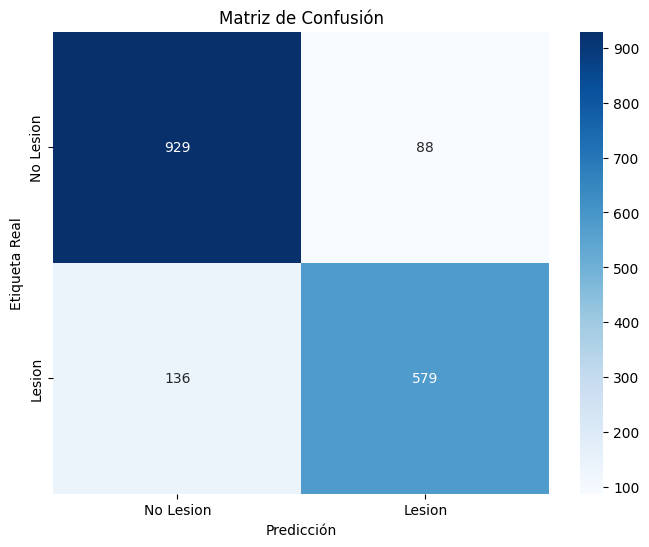

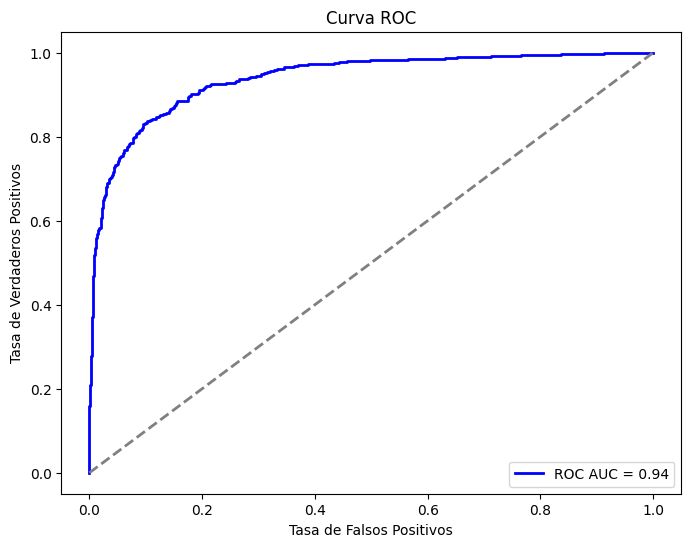

55/55 [==============================] - 10s 177ms/step


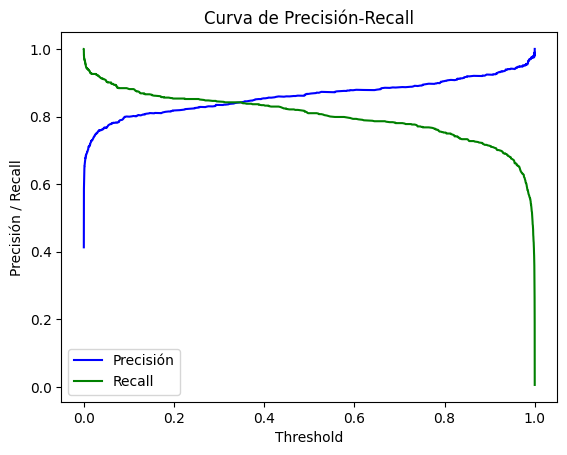

In [84]:
# Evaluar el modelo en el conjunto de prueba
evaluation_metrics = model.evaluate(test_generator)

# Asumiendo que tienes 5 métricas (loss, accuracy, precision, recall, auc)
test_loss, test_acc, test_precision, test_recall, test_auc = evaluation_metrics
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"AUC en el conjunto de prueba: {test_auc:.4f}")

# Generar predicciones y etiquetas verdaderas
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Reporte de clasificación
print(classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

In [85]:
# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 9s 172ms/step
Dimensiones de y_pred_proba: (1732, 1)
Dimensiones de y_true: (1732,)
Mejor threshold para F1-score: 0.43
Mejor F1-score: 0.8441281138790035


## 5. Entrenamiento y Evaluación del modelo Final (MovileNetV2)

In [148]:
# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.5),  # Dropout con un 50% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc')])  #tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
271/271 [==============================] - 16s 54ms/step - loss: 0.7804 - accuracy: 0.6275 - precision: 0.6424 - recall: 0.3979 - auc: 0.6750 - val_loss: 0.6802 - val_accuracy: 0.6636 - val_precision: 0.8359 - val_recall: 0.2286 - val_auc: 0.8056
Epoch 2/30
271/271 [==============================] - 15s 54ms/step - loss: 0.5586 - accuracy: 0.7217 - precision: 0.7051 - recall: 0.6611 - auc: 0.8042 - val_loss: 0.6012 - val_accuracy: 0.7075 - val_precision: 0.8683 - val_recall: 0.3422 - val_auc: 0.8492
Epoch 3/30
271/271 [==============================] - 15s 55ms/step - loss: 0.4783 - accuracy: 0.7664 - precision: 0.7508 - recall: 0.7236 - auc: 0.8548 - val_loss: 0.5148 - val_accuracy: 0.7607 - val_precision: 0.8551 - val_recall: 0.5049 - val_auc: 0.8725
Epoch 4/30
271/271 [==============================] - 15s 55ms/step - loss: 0.4475 - accuracy: 0.7851 - precision: 0.7687 - recall: 0.7506 - auc: 0.8731 - val_loss: 0.4565 - val_accuracy: 0.7942 - val_precision: 0.8426 - val_r

In [153]:
model.save('modelosFinales/movileNet_clasificacionBinaria_augmentation.keras')

55/55 [==============================] - 2s 40ms/step - loss: 0.3351 - accuracy: 0.8770 - precision: 0.8515 - recall: 0.8503 - auc: 0.9445
Precisión en el conjunto de prueba: 0.8770
Recall en el conjunto de prueba: 0.8503
Precision en el conjunto de prueba: 0.8515
AUC en el conjunto de prueba: 0.9445
55/55 [==============================] - 2s 36ms/step
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1017
           1       0.85      0.85      0.85       715

    accuracy                           0.88      1732
   macro avg       0.87      0.87      0.87      1732
weighted avg       0.88      0.88      0.88      1732



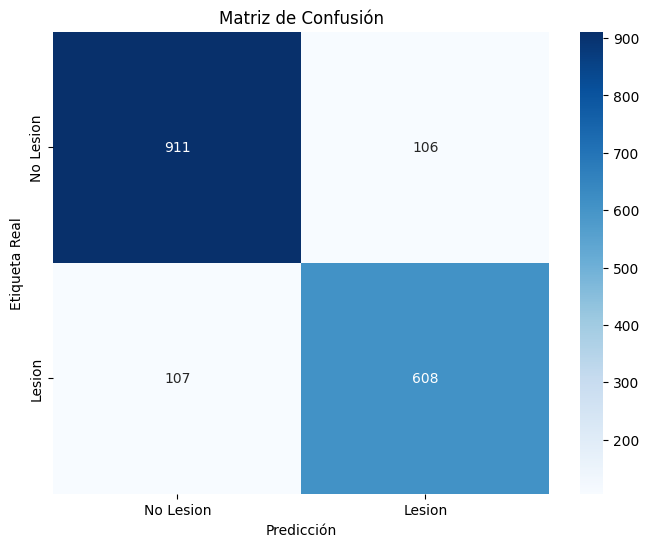

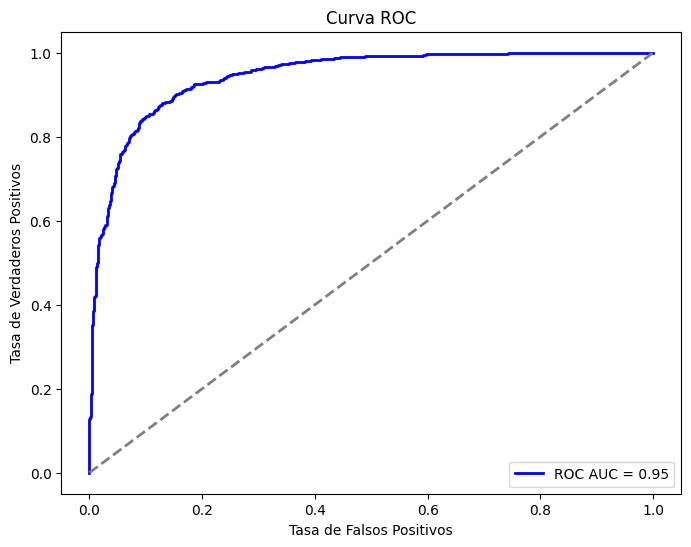

55/55 [==============================] - 2s 39ms/step


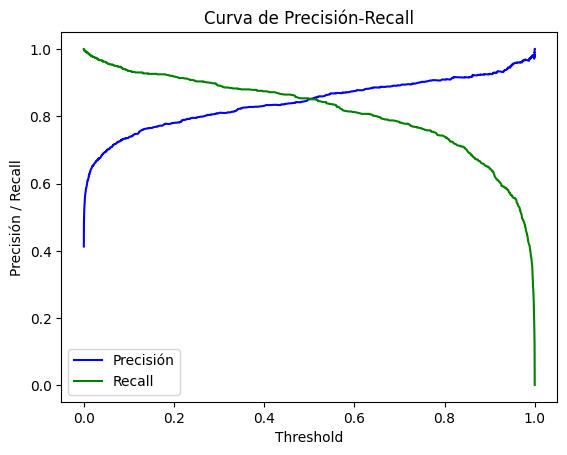

In [149]:
# Evaluar el modelo en el conjunto de prueba
evaluation_metrics = model.evaluate(test_generator)

# Asumiendo que tienes 5 métricas (loss, accuracy, precision, recall, auc)
test_loss, test_acc, test_precision, test_recall, test_auc = evaluation_metrics
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"AUC en el conjunto de prueba: {test_auc:.4f}")

# Generar predicciones y etiquetas verdaderas
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Reporte de clasificación
print(classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

**Ejemplo del modelo entrenado utilizado para predecir una imagen**

In [150]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Cargar el modelo completo desde un archivo .h5
modelo_cargado = load_model('modelosFinales/movileNet_clasificacionBinaria.h5')

# Verificar la estructura del modelo
modelo_cargado.summary()

# Cargar y preprocesar una imagen
img_path = 'crops_aug/test/1_lesion/HSIL/1a1319ef78624dc20d4a43cadde1da01_HSIL_10.png'
img = load_img(img_path, target_size=(96, 96))  # Asegúrate de redimensionar la imagen
img_array = img_to_array(img)  # Convertir la imagen a un array de numpy
img_array = img_array / 255.0  # Reescalar la imagen si fue entrenada con ImageDataGenerator rescaled by 1./255
img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión extra para representar el batch (tamaño 1)

# Hacer predicción con el modelo cargado
predicciones = modelo_cargado.predict(img_array)

# Mostrar la predicción
print(predicciones)

NameError: name 'load_model' is not defined

In [151]:
import numpy as np
from sklearn.metrics import recall_score

# Obtener las probabilidades predichas y las etiquetas verdaderas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
recall_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el recall solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        recall = recall_score(y_true, y_pred)
        recall_scores.append(recall)
    else:
        recall_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el recall máximo y el threshold más alto correspondiente
max_recall = np.max(recall_scores)
best_threshold = max(thresholds[np.array(recall_scores) == max_recall])

print(f'Mejor threshold más alto optimizando Recall: {best_threshold}')
print(f'Máximo Recall alcanzado: {max_recall}')

55/55 [==============================] - 2s 34ms/step
Dimensiones de y_pred_proba: (1732, 1)
Dimensiones de y_true: (1732,)
Mejor threshold más alto optimizando Recall: 0.01
Máximo Recall alcanzado: 0.9874125874125874
